# Extract phenology from OzFlux GPP

This is to show that the algorithm performs well regardless of NDVI or GPP

In [1]:
%matplotlib inline
import os
import sys
import pingouin as pg
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import distinctipy
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.simplefilter(action='ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import xr_phenometrics

In [2]:
# # Savitsky-Golay smoothing function
def sg_smooth(ds, window, poly, deriv):
    return xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=window,
            polyorder=poly,
            deriv=deriv,
            mode='interp'),
        dask='parallelized'
    )

def filter_complete_years(ds):
    # Extract year and month information
    df = ds.time.to_dataframe().reset_index(drop=True)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12]  # Keep only years with exactly 12 unique months
        .index
    )
    
    # Filter the data array to include only these complete years
    filtered_data = ds.where(ds.time.dt.year.isin(complete_years), drop=True)
    
    return filtered_data

## Flux towers

### Get flux data
Just get two sites as examples.

In [3]:
base = '/g/data/os22/chad_tmp/Aus_phenology/'
sites = os.listdir(f'{base}data/ozflux/')
homogenous = ['AliceSpringsMulga','HowardSprings'
             ]
flux_ts = {}
for site in sites:
    if '.csv' in site:
        if any(h in site for h in homogenous): #only homogenous sites
            # print(site[0:-4])
            xx = pd.read_csv(f'{base}data/ozflux/{site}',
                             index_col='time', parse_dates=True)
    
            #convert to 1d xarray
            lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
            xx = xx[['GPP_SOLO_EC']]  #'x_coord', 'y_coord'
            xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
            xx = xx['GPP_SOLO_EC'].squeeze()
            xx['time'] = xx.time.astype('datetime64[D]')
            flux_ts[site[0:-4]] = xx
        else:
            continue

#### Process timeseries and calculate phenometrics

In [52]:
flux_pheno = {}
flux_tss = {}
flux_tss_orig = {}

for k,v in flux_ts.items():
    print(k)
    
    # Index NDVI at location and time so we have matching time series
    lat,lon = v.latitude, v.longitude
    
    #remove incomplete years
    v = filter_complete_years(v)
    
    v_up = v.resample(time="2W").interpolate("linear")
    v_up=sg_smooth(v_up,window=11, poly=3, deriv=0)
    v_up = v_up.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')
    
    # # #phenology
    v_phen = xr_phenometrics(v_up, prominence=1, soil_signal=0.0).compute()

    # add results to dict for plotting
    flux_tss_orig[k] = v
    flux_tss[k] = v_up
    flux_pheno[k] = v_phen


AliceSpringsMulga
HowardSprings


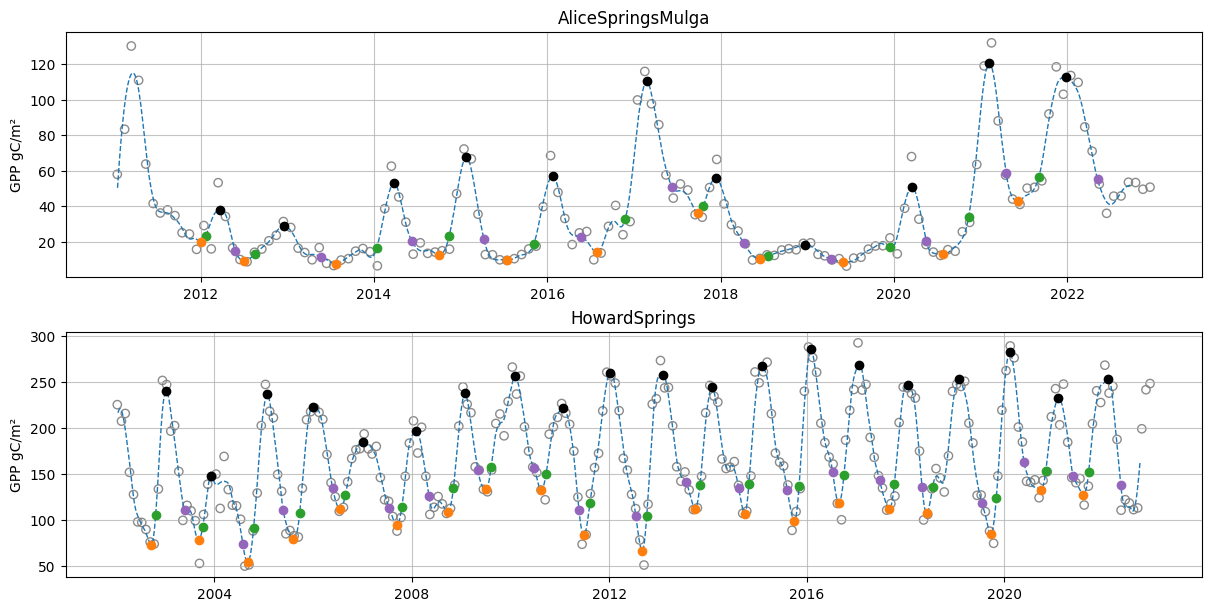

In [63]:

fig,axes = plt.subplots(2,1, figsize=(12,6), layout='constrained')
for ax, (k,v) in zip(axes.reshape(-1), flux_tss.items()):

    v.plot(ax=ax, c='tab:blue', linestyle='--', linewidth=1.0, label='Daily GPP')
    
    flux_tss_orig[k].squeeze().drop_vars(['latitude', 'longitude']).plot.scatter(ax=ax, label='Monthly GPP', alpha=0.9, facecolors='none', edgecolors='tab:gray')
    
    ax.set_title(k)
    ax.grid(axis='y', which='both')
    ax.set_xlabel(None)
    ax.set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}')
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(flux_pheno[k].SOS.values[0][0], flux_pheno[k].SOS_year.values[0][0])],
               y=flux_pheno[k].vSOS,
              c='tab:green', label='SOS', zorder=10)
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(flux_pheno[k].EOS.values[0][0], flux_pheno[k].EOS_year.values[0][0])],
               y=flux_pheno[k].vEOS,
              c='tab:purple', label='EOS', zorder=10)
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(flux_pheno[k].POS.values[0][0], flux_pheno[k].POS_year.values[0][0])],
                   y=flux_pheno[k].vPOS,
                  c='black', label='POS', zorder=10)
        
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(flux_pheno[k].TOS.values[0][0], flux_pheno[k].TOS_year.values[0][0])],
               y=flux_pheno[k].vTOS,
              c='tab:orange', label='TOS', zorder=10)
    ax.grid(alpha=0.75)
    # ax.legend()
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/GPP_phenology_ozflux.png',
            bbox_inches='tight', dpi=300)

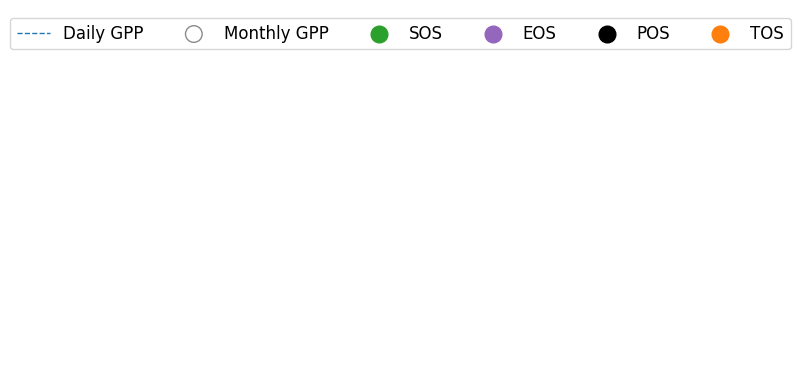

In [65]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="best", fontsize=12, markerscale=2, ncol=6)
figl.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/legend_GPP_phenology.png',
          bbox_inches='tight', dpi=300);